In [47]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
#import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
tf.__version__

'2.1.0'

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17482869699433620386
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4722519346372957490
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3365022984689645217
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 14542361133014516216
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:86:00.0, compute capability: 3.5"
]


In [6]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 0
TRANSLATION = 5

In [7]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [8]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [9]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

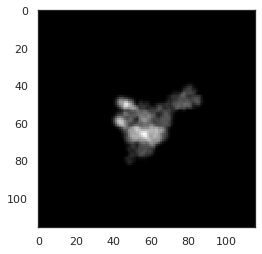

In [10]:
sampleProj = projections[1,:,:]
plt.imshow(sampleProj,cmap='gray')
plt.show()

In [11]:
def add_gaussian_noise(projections, noise_var):
    noise_sigma   = noise_var**0.5
    nproj,row,col = projections.shape
    gauss_noise   = np.random.normal(0,noise_sigma,(nproj,row,col))
    gauss_noise   = gauss_noise.reshape(nproj,row,col) 
    projections   = projections + gauss_noise
    return projections

In [12]:
def add_triangle_translation(projections, left_limit, peak_limit, right_limit):
    horizontal_shift = np.random.triangular(left_limit, peak_limit, right_limit, len(projections))
    vertical_shift   = np.random.triangular(left_limit, peak_limit, right_limit, len(projections))
    for i, (hs, vs) in enumerate(zip(horizontal_shift, vertical_shift)):
        # shift 1 place in horizontal axis
        projections[i] = np.roll(projections[i], int(hs), axis=0)
        # shift 1 place in vertical axis
        projections[i] = np.roll(projections[i], int(vs), axis=1) 
    return projections

In [13]:
# Add zero-mean Gaussian noise on the projections 
projections = add_gaussian_noise(projections, NOISY_VAR)
projections = add_triangle_translation(projections, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION)

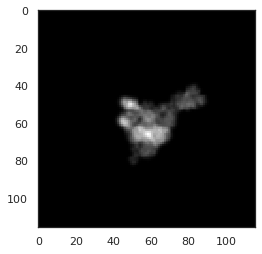

In [14]:
# Display projections with/out noise (for comparison)
sampleProj = projections[1,:,:]
plt.imshow(sampleProj,cmap='gray')
plt.show()

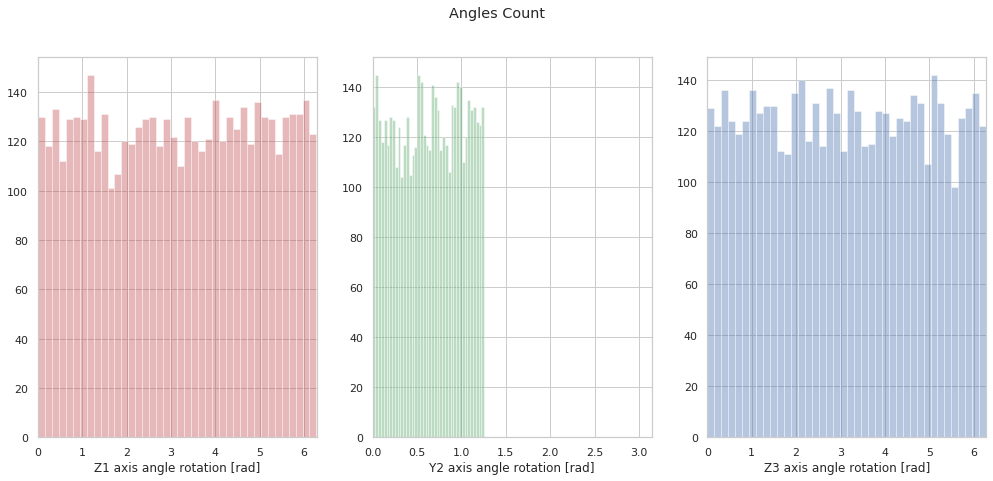

In [15]:
plot_angles_count(angles_true)

In [16]:
from cryoem.distance_estimation import global_standardization

In [17]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [18]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [19]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [20]:
X.shape

(5000, 116, 116, 1)

---

## Angle Recovery: Estimated Distance FULL

In [21]:
model_filename = f"/mnt/scratch/students/translation{TRANSLATION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [22]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [23]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [24]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

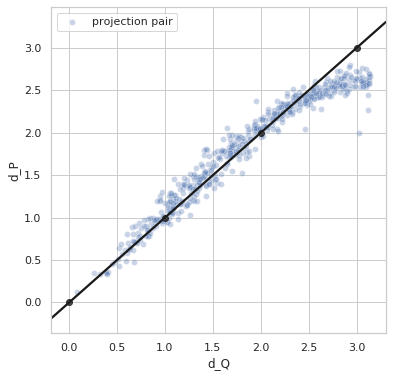

<Figure size 432x288 with 0 Axes>

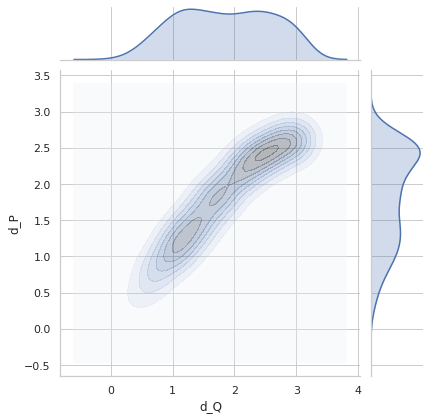

Variance = 0.195360653545823
Min. angle recovery loss possible = 0.03809124240511309


In [25]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [26]:
from cryoem.angle_recovery import train_angle_recovery

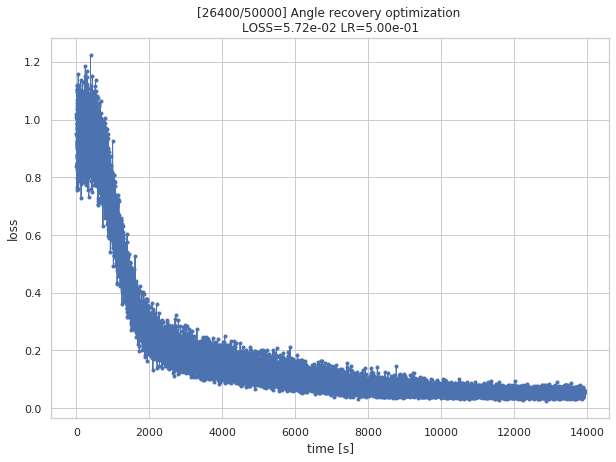

Shape of projections: (5000, 116, 116, 1)step 5000/50000 (2367s): loss = 2.12e-01
step 10000/50000 (4795s): loss = 1.07e-01
step 15000/50000 (7349s): loss = 6.42e-02
step 20000/50000 (10101s): loss = 4.90e-02
step 25000/50000 (13046s): loss = 4.65e-02
step 26400/50000 (13911s): loss = 5.96e-02



In [27]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X, 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_translation{TRANSLATION}_limited3.14_estimated_50k")

In [28]:
from cryoem.conversions import quaternion2euler

In [29]:
data = np.load(f"/mnt/scratch/students/angle_recovery_translation{TRANSLATION}_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

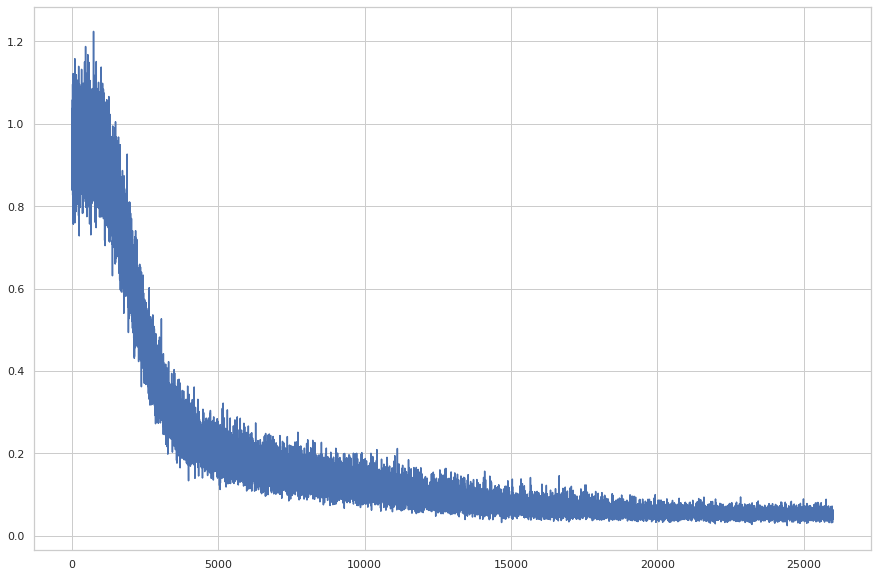

In [30]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[:26000])
plt.show()

In [31]:
np.mean(losses[:26000][-10:])

0.051554071175521646

In [32]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save(f"/mnt/scratch/studetns/angles_predicted_noisy{NOISY_VAR}_limited3.14_estimated_50k", angles_predicted)

### Angle Alignment

In [33]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

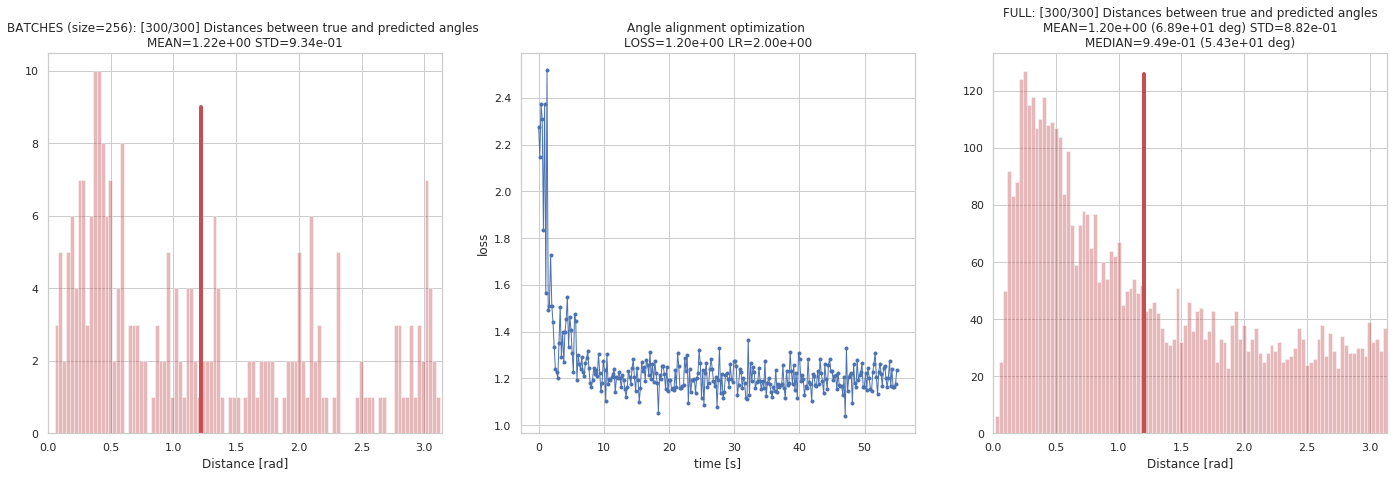

step 30/300 (7s): loss = 1.61e+00
step 60/300 (12s): loss = 1.25e+00
step 90/300 (17s): loss = 1.20e+00
step 120/300 (22s): loss = 1.21e+00
step 150/300 (28s): loss = 1.21e+00
step 180/300 (33s): loss = 1.20e+00
step 210/300 (38s): loss = 1.18e+00
step 240/300 (43s): loss = 1.20e+00
step 270/300 (48s): loss = 1.20e+00
step 300/300 (56s): loss = 1.21e+00



In [34]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

In [35]:
losses[-1], m, a_R

(1.0955292168538215,
 [1.0, 1.0, 1.0, -1.0],
 [<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
  array([ 18.27145807,  -5.77283619,   5.41658608, -33.40151784,
          10.29303596, -20.7113143 ])>])

In [36]:
m = m
trajectory_first = trajectory[0]
loss_first = losses[0]
trajectory_last = trajectory[-1]
loss_last = losses[-1]

In [37]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 array([0.57649746, 3.4635529 , 5.12147197, 3.14438545, 2.29092488,
        0.90425129]),
 2.2391205422531044,
 array([ 18.27145807,  -5.77283619,   5.41658608, -33.40151784,
         10.29303596, -20.7113143 ]),
 1.0955292168538215)

In [38]:
tick_size=15
label_size=15

(5000, 4)
(5000, 4)


Text(0.77, 0.72, '$E$ = 2.2391 rad')

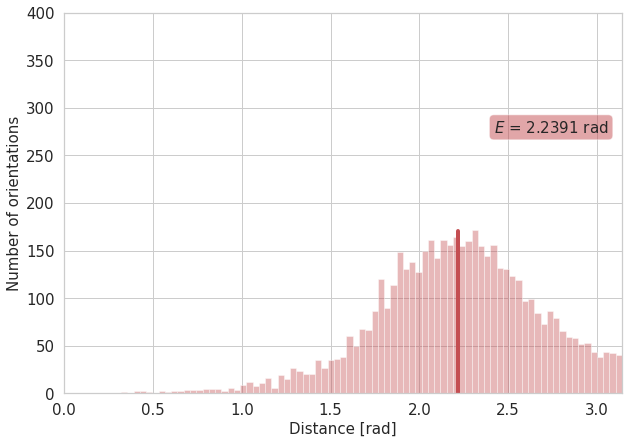

In [39]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
print(q_predicted.shape)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted))
print(q_predicted_rot.shape)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 400)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 1.0955 rad')

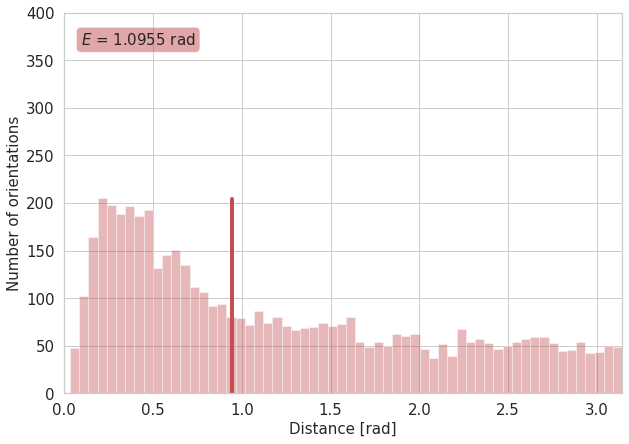

In [40]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 400)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=60, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

In [41]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

#np.save(f"/mnt/scratch/studetns/angles_predicted_rotated_noisy{NOISY_VAR}_limited3.14_estimated_50k", angles_predicted_rotated)

In [42]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [43]:
plot_iterations_polar_plot(collect_data, angles_true, interval=200, connections=False, selected=None)

In [46]:
ipv.screenshot()

Output()

In [44]:
plot_iterations_rotvec(collect_data, angles_true, interval=200)

ERROR! Session/line number was not unique in database. History logging moved to new session 891


In [45]:
#np.save("data/5j0n/projections_noisy16", projections)